# TEXT SUMMARIZATION

### Theory

**Text summarization** is a Natural Language Processing application which produces short and meaningful summary of a lengthy paragraph thereby helping us to understand the essence of the topic in an efficient way.

**Types of Text Summarization**

1. Abstrative Based
2. Extractive Based



In Abstractive based, we generate new sentences from the original text. The sentences generated through abstractive summarization might not be present in the original text.

In Extractive based, we identify the important sentences or phrases from the original text and extract only those from the text. Those extracted sentences would be our summary. 

Custom Attention Layer: Keras does not officially support attention layer. A third-party implementation of the attention layer was used.

## Import the Libraries

In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from keras.utils import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## Third party implementation

### Attention Class

In [2]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

## Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

Taking a sample of 3000 reviews to reduce the training time of our model.

In [3]:
df = pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv")
data = df[:3000]

## Drop Duplicates and NA values

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

## Text Pre-processing

Before developing the model, some basic preprocessing tasks must be completed. Using messy and sloppy text data can be devastating. As a result, in this stage, all unneeded and unnecessary symbols, characters, and other elements will be removed from the text so that they do not affect the problem's goal.

Here is the dictionary that we will use for expanding the contractions:

In [5]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

The following pre-processing tasks will be done on the data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove single characters

**Defining the function for performing the above pre-processing steps**

In [6]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [7]:
# Cleaning the "Text" Column

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

Cross-checking

In [8]:
cleaned_text[:2]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo']

In [9]:
# Cleaning the "Summary" Column

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Cross-checking

In [10]:
cleaned_summary[:2]

['good quality dog food', 'not as advertised']

In [11]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

## Drop empty rows

In [12]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Understanding the distribution of the sequences

Here, the length of the reviews and the summary will be analyzed to get an overall idea about the distribution of length of the text. This will help fix the maximum length of the sequence:

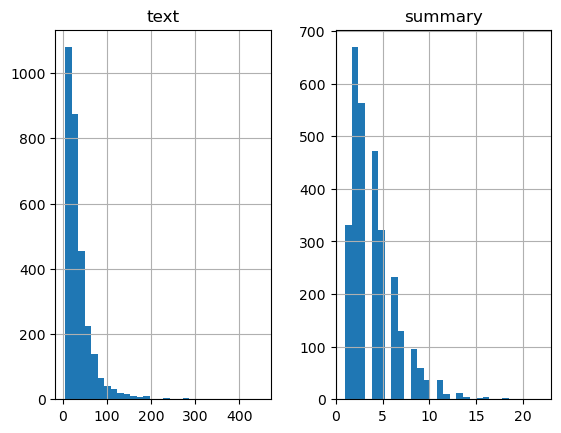

In [13]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

**NOTE: We can fix the maximum length of the summary to 8: it seems fairly good to use**

Understanding the proportion of the length of summaries below 8

In [14]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.942397856664434


**We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.**

In [15]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 30):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.5907568653717348


Let us fix the maximum length of review to 80

In [16]:
max_text_len=80
max_summary_len=10

Selecting the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [17]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

#### add the START and END special tokens at the beginning and end of the summary. Here, We have chosen **sostok** and **eostok** as START and END tokens

In [19]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,text,summary
0,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,sostok good quality dog food eostok
1,product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,sostok not as advertised eostok
2,confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,sostok delight says it all eostok
3,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,sostok cough medicine eostok
4,great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,sostok great taffy eostok


## A Rough BaseLine MODEL 

#### The baseline model score will be calculated with RougeScore

In [20]:
from datasets import load_metric
metric = load_metric("rouge")

def calc_rouge_scores(candidates, references):
    result = metric.compute(predictions=candidates, references=references, use_stemmer=True)
    result = {key: round(value.mid.fmeasure * 100, 1) for key, value in result.items()}
    return result

In [21]:
import re

ref_summaries = list(df['summary'])

for i in range (3):
    candidate_summaries = list(df['text'].apply(lambda x: ' '.join(re.split(r'(?<=[.:;])\s', x)[:i+1])))
    print(f"First {i+1} senctences: Scores {calc_rouge_scores(candidate_summaries, ref_summaries)}")

First 1 senctences: Scores {'rouge1': 8.6, 'rouge2': 1.7, 'rougeL': 8.0, 'rougeLsum': 8.0}
First 2 senctences: Scores {'rouge1': 8.6, 'rouge2': 1.7, 'rougeL': 8.0, 'rougeLsum': 8.0}
First 3 senctences: Scores {'rouge1': 8.6, 'rouge2': 1.7, 'rougeL': 8.0, 'rougeLsum': 8.0}


## Train-Test Split and Prepare the Tokenizer

In [22]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=0, shuffle=True) 

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

## Rarewords and its Coverage on Reviews column

The threshold is taken as 4 which means word whose count is below 4 is considered as a **rare word**

In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 68.09064860640792
Total Coverage of rare words: 10.557568009091554


In [24]:
print(cnt),print(tot_cnt)

5228
7678


(None, None)

In [25]:
print(freq),print(tot_freq)

7432
70395


(None, None)

NOTE:

* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)
 
*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words 

Let us define the tokenizer with **top most common words** for reviews.

## Reviews Tokenizer

In [26]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [27]:
x_voc

2451

## Summary Tokenizer

In [28]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

## Rarewords and its Coverage on the summary column

The threshold is taken as 6 which means word whose count is below 6 is considered as a **rare word**

In [29]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 86.36124275934702
Total Coverage of rare words: 19.34057971014493


In [30]:
print(cnt),print(tot_cnt)

1640
1899


(None, None)

In [31]:
print(freq),print(tot_freq)

2669
13800


(None, None)

Let us define the tokenizer with **top most common words for summary**.

In [32]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

#### deleting the rows that contain only START and END tokens

In [34]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [35]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Abstractive Text Summarization - Model building

  ##  **Model building**
    
### important terms:

   #### **Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

   #### **Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

   #### **Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

   #### **Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. 
    
This leads to a better representation of the sequence.

Here, we are building a 3 stacked LSTM for the encoder:

In [36]:
latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 100)      245100      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 80, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

Sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

EarlyStopping monitors the validation loss (val_loss). Our model will stop training once the validation loss increases.

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

Fit the model

In [39]:
history=model.fit([x_tr, y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=128, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/50
18/18 [==============================] - 77s 4s/step - loss: 2.8337 - val_loss: 1.9349
Epoch 2/50
18/18 [==============================] - 61s 3s/step - loss: 2.0558 - val_loss: 1.9103
Epoch 3/50
18/18 [==============================] - 61s 3s/step - loss: 1.9907 - val_loss: 1.8415
Epoch 4/50
18/18 [==============================] - 61s 3s/step - loss: 1.9494 - val_loss: 1.7474
Epoch 5/50
18/18 [==============================] - 61s 3s/step - loss: 1.8331 - val_loss: 1.6871
Epoch 6/50
18/18 [==============================] - 61s 3s/step - loss: 1.7513 - val_loss: 1.6297
Epoch 7/50
18/18 [==============================] - 61s 3s/step - loss: 1.7148 - val_loss: 1.6066
Epoch 8/50
18/18 [==============================] - 61s 3s/step - loss: 1.6965 - val_loss: 1.6330
Epoch 9/50
18/18 [==============================] - 61s 3s/step - loss: 1.6850 - val_loss: 1.5902
Epoch 10/50
18/18 [==============================] - 60s 3s/step - loss: 1.6769 - val_loss: 1.5908
Epoch 11/50
18/18 [

## Understanding the Diagnostic plot

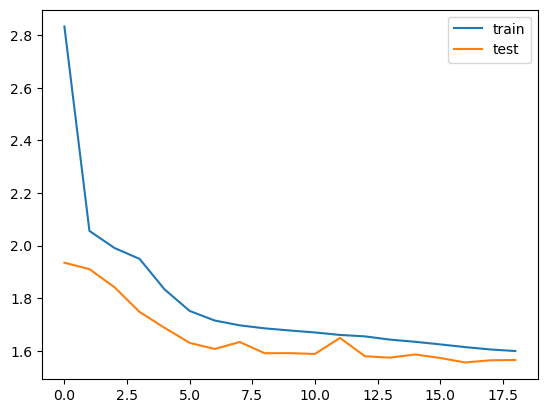

In [40]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Building the dictionary to convert the index to word for target and source vocabulary:

In [41]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Inference

Set up the inference for the encoder and decoder:

In [42]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

Defining a function below which is the implementation of the inference process

In [43]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Defining the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [44]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

#### Importing Rouge and creating an instance of the class

In [68]:
from rouge import Rouge
ROUGE =  Rouge()

In [71]:
for i in range(0, 20):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")
#     print(ROUGE.get_scores(decode_sequence(x_tr[i].reshape(1,max_text_len)), seq2summary(y_tr[i])))
#     print("\n")

Review: nd order placed bob red mill organic flaxseed good quality whole flaxseed grind little time sprinkle cereal yogurt keeps long time freezer using flaxseed year eating tablespoon every day noticed skin softer plus keeps regular ya know mean flaxseed also good way get omega body needs 
Original summary: organic 
1/1 [==============================] - 0s 27ms/step
Predicted summary:  great


Review: smooth full flavor bitter nasty aftertaste people like extra bold starbucks french roast dark cup love better 
Original summary: love it 
1/1 [==============================] - 0s 27ms/step
Predicted summary:  great


Review: started outside house started feeding rather buying smaller bags great value multiple cats love food always look forward eating shipped right door cannot go wrong 
Original summary: great value 
1/1 [==============================] - 0s 27ms/step
Predicted summary:  great


Review: let first say eat cereal general like drink milk ever eating dry cereal always treat

## USING LARGE BART CNN

Here, The preprocessed steps that were done above will be used and the text will be passed to a summarizer that will summarize the text and the results will be compared to the first model.

In [73]:
from transformers import pipeline

In [92]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
for i in range(20):
    summary = summarizer(df['text'][i], min_length=5, max_length=25,do_sample=False)
    print('Text: {} \n Summary: {}'.format(df['text'][i], summary))

Your max_length is set to 25, but you input_length is only 24. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Text: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better 
 Summary: [{'summary_text': 'Good quality product looks like stew processed meat smells better labrador finicky appreciates product better. bought several vitality'}]
Text: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo 
 Summary: [{'summary_text': ' product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo'}]


Your max_length is set to 25, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Text: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch 
 Summary: [{'summary_text': 'Crisp citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven'}]


Your max_length is set to 25, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Text: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal 
 Summary: [{'summary_text': ' root beer extract ordered made cherry soda flavor medicinal. looking secret ingredient robitussin believe found got addition root'}]
Text: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal 
 Summary: [{'summary_text': 'Great taffy great price wide assortment yummy taffi delivery quick taffo lover deal.'}]
Text: got wild hair taffy ordered five pound bag taffy enjoyable many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces kids husband lasted two weeks would recommend brand taffy delightful treat 
 Summary: [{'summary_text': 'Many flavors watermelon root beer melon peppermint grape etc complaint bit much red black licorice flavored pieces'}]


Your max_length is set to 25, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Text: saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version fralinger would highly recommend candy served beach themed party everyone loved 
 Summary: [{'summary_text': ' saltwater taffy great flavors soft chewy candy individually wrapped well none candies stuck together happen expensive version'}]


Your max_length is set to 25, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Text: taffy good soft chewy flavors amazing would definitely recommend buying satisfying 
 Summary: [{'summary_text': ' taffy good soft chewy flavors amazing would definitely recommend buying some.'}]


Your max_length is set to 25, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


Text: right mostly sprouting cats eat grass love rotate around wheatgrass rye 
 Summary: [{'summary_text': 'Right now mostly sprouting cats eat grass. Love rotate around wheatgrass rye.'}]
Text: healthy dog food good digestion also good small puppies dog eats required amount every feeding 
 Summary: [{'summary_text': ' healthy dog food good digestion also good small puppies dog eats required amount every feeding.'}]
Text: know cactus tequila unique combination ingredients flavour hot sauce makes one kind picked bottle trip brought back home us totally blown away realized simply could find anywhere city bummed magic internet case sauce ecstatic love hot sauce mean really love hot sauce want sauce tastelessly burns throat grab bottle tequila picante gourmet de inclan realize taste never want use sauce thank personal incredible service 
 Summary: [{'summary_text': 'Hot sauce is one of the most popular condiments in the world. Hot sauce is made from cactus te'}]


Your max_length is set to 25, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Text: cats happily eating felidae platinum two years got new bag shape food different tried new food first put bowls bowls sit full kitties touch food noticed similar reviews related formula changes past unfortunately need find new food cats eat 
 Summary: [{'summary_text': 'Kitties happily eating felidae platinum two years got new bag shape food different tried new food first put bowls'}]


Your max_length is set to 25, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Text: good flavor came securely packed fresh delicious love twizzlers 
 Summary: [{'summary_text': 'Good flavor came securely packed fresh delicious love twizzlers.'}]


Your max_length is set to 25, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


Text: strawberry twizzlers guilty pleasure yummy six pounds around son 
 Summary: [{'summary_text': 'Strawberry twizzlers are my guilty pleasure. Six pounds around son is too much.'}]


Your max_length is set to 25, but you input_length is only 21. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


Text: daughter loves twizzlers shipment six pounds really hit spot exactly would expect six packages strawberry twizzlers 
 Summary: [{'summary_text': 'Six packages of strawberry twizzlers were shipped to the U.S. from Canada. The shipment of six'}]


Your max_length is set to 25, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


Text: love eating good watching tv looking movies sweet like transfer zip lock baggie stay fresh take time eating 
 Summary: [{'summary_text': 'Love eating good watching tv looking movies sweet like transfer zip lock baggie stay fresh take time eating.'}]
Text: satisfied twizzler purchase shared others enjoyed definitely ordering 
 Summary: [{'summary_text': 'A satisfied twizzler purchase shared with others others enjoyed definitely ordering.'}]


Your max_length is set to 25, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


Text: twizzlers strawberry childhood favorite candy made lancaster pennsylvania candies inc one oldest confectionery firms united states subsidiary hershey company company established young smylie also make apple licorice twists green color blue raspberry licorice twists like alli keep dry cool place recommended put fridge according guinness book records longest licorice twist ever made measured feet weighted pounds made candies inc record breaking twist became guinness world record july product kosher thank 
 Summary: [{'summary_text': 'Longest licorice twist ever made measured feet weighted pounds made candies inc record breaking twist became guinness'}]
Text: candy delivered fast purchased reasonable price home bound unable get store perfect 
 Summary: [{'summary_text': 'Candy delivered fast purchased reasonable price home bound unable to get store perfect.'}]
Text: husband twizzlers addict bought many times amazon government employees living overseas cannot get country assigned alw

### Calcuating the **ROUGE SCORE** for the CNN Algorithm

In [93]:
for i in range(20):
    summary = summarizer(df['text'][i], min_length=5, max_length=25,do_sample=False)
    print("ROUGE SCORE")
    print(ROUGE.get_scores(summary[0]['summary_text'],df['text'][i]))

Your max_length is set to 25, but you input_length is only 24. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


ROUGE SCORE
[{'rouge-1': {'r': 0.7142857142857143, 'p': 0.9375, 'f': 0.8108108059021184}, 'rouge-2': {'r': 0.6818181818181818, 'p': 0.8823529411764706, 'f': 0.7692307643129521}, 'rouge-l': {'r': 0.7142857142857143, 'p': 0.9375, 'f': 0.8108108059021184}}]
ROUGE SCORE
[{'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}]


Your max_length is set to 25, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


ROUGE SCORE
[{'rouge-1': {'r': 0.3888888888888889, 'p': 0.9333333333333333, 'f': 0.5490196036908882}, 'rouge-2': {'r': 0.3684210526315789, 'p': 0.9333333333333333, 'f': 0.5283018827340691}, 'rouge-l': {'r': 0.3888888888888889, 'p': 0.9333333333333333, 'f': 0.5490196036908882}}]


Your max_length is set to 25, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


ROUGE SCORE
[{'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 0.9411764705882353, 'f': 0.9696969647015611}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}]
ROUGE SCORE
[{'rouge-1': {'r': 1.0, 'p': 0.7692307692307693, 'f': 0.8695652124763706}, 'rouge-2': {'r': 0.5833333333333334, 'p': 0.5833333333333334, 'f': 0.5833333283333335}, 'rouge-l': {'r': 1.0, 'p': 0.7692307692307693, 'f': 0.8695652124763706}}]
ROUGE SCORE
[{'rouge-1': {'r': 0.4444444444444444, 'p': 0.9411764705882353, 'f': 0.6037735805482378}, 'rouge-2': {'r': 0.40540540540540543, 'p': 0.9375, 'f': 0.5660377316340335}, 'rouge-l': {'r': 0.4444444444444444, 'p': 0.9411764705882353, 'f': 0.6037735805482378}}]


Your max_length is set to 25, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


ROUGE SCORE
[{'rouge-1': {'r': 0.6296296296296297, 'p': 1.0, 'f': 0.7727272679855373}, 'rouge-2': {'r': 0.5925925925925926, 'p': 1.0, 'f': 0.7441860418388319}, 'rouge-l': {'r': 0.6296296296296297, 'p': 1.0, 'f': 0.7727272679855373}}]


Your max_length is set to 25, but you input_length is only 15. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


ROUGE SCORE
[{'rouge-1': {'r': 0.9090909090909091, 'p': 0.9090909090909091, 'f': 0.9090909040909091}, 'rouge-2': {'r': 0.9, 'p': 0.9, 'f': 0.899999995}, 'rouge-l': {'r': 0.9090909090909091, 'p': 0.9090909090909091, 'f': 0.9090909040909091}}]


Your max_length is set to 25, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


ROUGE SCORE
[{'rouge-1': {'r': 0.8181818181818182, 'p': 0.75, 'f': 0.7826086906616257}, 'rouge-2': {'r': 0.7, 'p': 0.6363636363636364, 'f': 0.6666666616780046}, 'rouge-l': {'r': 0.8181818181818182, 'p': 0.75, 'f': 0.7826086906616257}}]
ROUGE SCORE
[{'rouge-1': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-2': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}, 'rouge-l': {'r': 1.0, 'p': 1.0, 'f': 0.999999995}}]
ROUGE SCORE
[{'rouge-1': {'r': 0.05660377358490566, 'p': 0.2, 'f': 0.08823529067906588}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.03773584905660377, 'p': 0.13333333333333333, 'f': 0.0588235259731836}}]


Your max_length is set to 25, but you input_length is only 13. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


ROUGE SCORE
[{'rouge-1': {'r': 0.5, 'p': 0.9411764705882353, 'f': 0.6530612199583508}, 'rouge-2': {'r': 0.4594594594594595, 'p': 0.9444444444444444, 'f': 0.6181818137785124}, 'rouge-l': {'r': 0.5, 'p': 0.9411764705882353, 'f': 0.6530612199583508}}]


Your max_length is set to 25, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


ROUGE SCORE
[{'rouge-1': {'r': 0.8888888888888888, 'p': 0.8888888888888888, 'f': 0.888888883888889}, 'rouge-2': {'r': 0.875, 'p': 0.875, 'f': 0.874999995}, 'rouge-l': {'r': 0.8888888888888888, 'p': 0.8888888888888888, 'f': 0.888888883888889}}]


Your max_length is set to 25, but you input_length is only 22. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=11)


ROUGE SCORE
[{'rouge-1': {'r': 0.6666666666666666, 'p': 0.46153846153846156, 'f': 0.5454545406198348}, 'rouge-2': {'r': 0.375, 'p': 0.25, 'f': 0.29999999520000004}, 'rouge-l': {'r': 0.6666666666666666, 'p': 0.46153846153846156, 'f': 0.5454545406198348}}]


Your max_length is set to 25, but you input_length is only 21. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)


ROUGE SCORE
[{'rouge-1': {'r': 0.35714285714285715, 'p': 0.3125, 'f': 0.33333332835555557}, 'rouge-2': {'r': 0.06666666666666667, 'p': 0.0625, 'f': 0.06451612403746138}, 'rouge-l': {'r': 0.35714285714285715, 'p': 0.3125, 'f': 0.33333332835555557}}]


Your max_length is set to 25, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


ROUGE SCORE
[{'rouge-1': {'r': 0.9411764705882353, 'p': 0.9411764705882353, 'f': 0.9411764655882354}, 'rouge-2': {'r': 0.9411764705882353, 'p': 0.9411764705882353, 'f': 0.9411764655882354}, 'rouge-l': {'r': 0.9411764705882353, 'p': 0.9411764705882353, 'f': 0.9411764655882354}}]
ROUGE SCORE
[{'rouge-1': {'r': 1.0, 'p': 0.8, 'f': 0.8888888839506174}, 'rouge-2': {'r': 0.8571428571428571, 'p': 0.6, 'f': 0.7058823480968859}, 'rouge-l': {'r': 1.0, 'p': 0.8, 'f': 0.8888888839506174}}]


Your max_length is set to 25, but you input_length is only 14. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=7)


ROUGE SCORE
[{'rouge-1': {'r': 0.23728813559322035, 'p': 0.9333333333333333, 'f': 0.37837837514609207}, 'rouge-2': {'r': 0.22388059701492538, 'p': 0.9375, 'f': 0.3614457800203223}, 'rouge-l': {'r': 0.23728813559322035, 'p': 0.9333333333333333, 'f': 0.37837837514609207}}]
ROUGE SCORE
[{'rouge-1': {'r': 0.9166666666666666, 'p': 0.8461538461538461, 'f': 0.879999995008}, 'rouge-2': {'r': 0.8181818181818182, 'p': 0.75, 'f': 0.7826086906616257}, 'rouge-l': {'r': 0.9166666666666666, 'p': 0.8461538461538461, 'f': 0.879999995008}}]
ROUGE SCORE
[{'rouge-1': {'r': 0.782608695652174, 'p': 0.9473684210526315, 'f': 0.8571428521882086}, 'rouge-2': {'r': 0.7272727272727273, 'p': 0.8888888888888888, 'f': 0.79999999505}, 'rouge-l': {'r': 0.782608695652174, 'p': 0.9473684210526315, 'f': 0.8571428521882086}}]


### Overall:

##### From the above results, it is evident and clear that the summary for both algorithms are different and both perform based on their respective approach.

##### While the first one is based on **ABSTRACTIVE** approach , the second one is based on the **EXTRACTIVE** approach. Both perform well on the data.